# Flooding stage 3 basin evolution - Western Mediterranean (wMed)

#### Here we compute the evolution of the mixing depth, mixed-layer salinity and density during the stage 3 of wMed flooding.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import pandas as pd
import gsw

## Upload data files here

In [5]:
KE              = np.loadtxt(fname="wMed_flow_KE.txt")          # Flow energy entering the wMed (From Script 1)
BPEad_wMed      = np.loadtxt(fname="wMed_added_BPE_Stage3.txt") # Added BPE to wMed during stage 3 (From Script 4)
SLrise_wMed     = np.loadtxt(fname="SL_rise_wMed.txt")          # Rise of wMed level (From Script 1)
Discharge       = np.loadtxt(fname="Discharge.txt")             # Flow discharge (From Script 1)
Hypsometry_wMed = np.loadtxt(fname="Hypsometry_Stage3_evolution.txt") # Reconstructed Mediterranean hypsometry 
                #(This file contains wMed hypsometry below the level of Sicily sill, and whole-Mediterranean hypsometry above)

## Setting parameters

(1027, 1080)

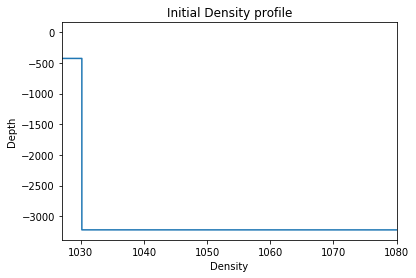

In [6]:
rho_SW   = 1027   # Inflowing sea-water density [kg m^-3]
S_Marine = 36.5   # Atlantic water salinity [PSU]
T_Brine  = 20     # Brine temperature [degrees Celcius]
g        = 9.81   # Acceleration due to gravity [m s^-2]
Mix_Ef   = 0.2    # Mixing efficiency

dzArray = np.linspace(0.5,3223.5,3224)  # Creates an array of mid-layer depths

Depth = Hypsometry_wMed[:,0]  # Reconstructed hypsometry -  total Mediterranean values above Sicily sill, and wMed values below.
DepthList = Depth.tolist()

Density=np.loadtxt(fname="wMed_DprofileStage2-20.txt")  # Uploads the density profile at the stage 2 termination
Salinity =np.loadtxt(fname="wMed_SprofileStage2-20.txt") # Uploads the salinity profile at the stage 2 termination

Area =(Hypsometry_wMed[:,1])*10**12          # Gives area with depth from surface towards bottom
Vol_wMed = (Hypsometry_wMed[:,3])*10**12     # Gives the cumulative volume from surface towards bottom
Volfrombot = (Hypsometry_wMed[:,2])*10**12   # Gives the cumulative volume from bottom towards surface

plt.figure()
plt.title('Initial Density profile')
plt.ylabel('Depth')
plt.xlabel('Density')
plt.plot(Density,-Depth)
plt.xlim([rho_SW,1080])

## Calculating wMed evolution parameters for stage 3

Here we use the same concept as in stage 1. 
Hypsometry file contains total Mediterranean values above Sicily sill, and wMed values below.

(38, 39.4)

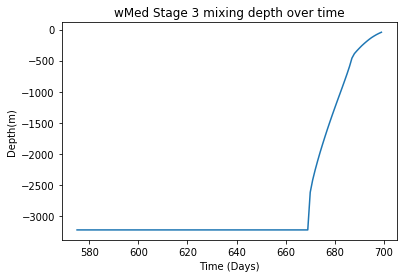

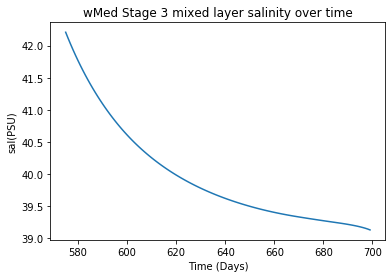

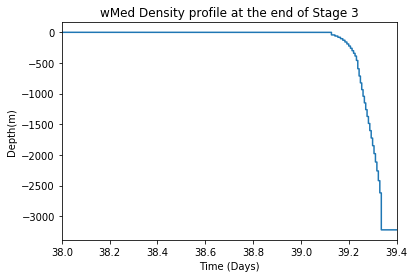

In [8]:
t = 575   # Starting time stage 3      
SLtruncated_wMed = np.trunc(SLrise_wMed)  # truncated values of sea-level
KEAv = KE*Mix_Ef  # Available kinetic energy

# Setting arrays used for calculations and plotting

SLArray     = [426.2966146]           # Sicily sill level (Closest value to 430, reached at an end of a complete day(387th day))
MixedD_wMed = [1030.1005436826104 ]   # Mixed layer density at the end of stage 2
MixedS_wMed = [42.18560672666315]     # Mixed layer salinity at the end of stage 2
Mdepth_wMed = []                      # Appends daily mixing depth [m]
Times       = []                      # Appends time [days]
D_profile   = []                      # Appends final density profile at the end of stage 3
S_profile   = []                      # Appends final salinity profile at the end of stage 3

Density=np.loadtxt(fname="wMed_DprofileStage2-20.txt")  # Uploads the density profile at the stage 1 termination
Salinity =np.loadtxt(fname="wMed_SprofileStage2-20.txt") # Uploads the salinity profile at the stage 1 termination

while t<700:
    empty_VolwMed = Vol_wMed[(int(SLtruncated_wMed[t-1]))] # empty_VolwMed is the total volume of the empty space above basin surface,

    SLwMed = SLrise_wMed[t-1]  # True sea level  (Daily sea level) of the PREVIOUS day
    SLArray.append(SLwMed)
    SLtWMed = int(SLtruncated_wMed[t-1])    # Truncated sea level at a given time

    SLNext_truncated = SLtruncated_wMed[t]  # Truncated sea level of following day

    AddedBPE_daily = BPEad_wMed[t-575]      # Total BPE of the daily added sea water layer
    Dis_daily = Discharge[t]*3600*24        # Daily discharge
    
    #print (AddedBPE_daily, 'Discharge',(Dis_daily),SLtWMed,SLwMed,SLNext_truncated)
    
    dH_wMed = (SLtWMed+1)-(SLArray[-1])     # thickness of water layer in the top incompletely-filled layer
    Area_dH = (Area[SLtWMed+1])             # area of the top incompletely-filled layer
    Vol_dH = dH_wMed*Area_dH                # Volume of fluids in top incompletely-filled layer
    
    #print ( dH_wMed,Area_dH,Vol_dH,(SLArray[-1]))
    
    # Emptying all the arrays in the loop to keep the script running
    
    MixD_wMed = []
    Product_AreaHt = []
    Volarray = []
    BPEMix = []
    BPE_perCell = []
    delta_BPE = []
    Depth_List = []
    Mixed_DList = []
    MixingDepth_wMed = []
    BPE_mixed = []
    D_MixedLayer = []
    index_a = []
    index_b = []
    DenVolw = []
    DenVolTw = []
    Sal_Vol = []
    SalVol_cumulative = []
    Mixed_Sal = []
    BPEi_TotalwMed = []
    BPE_Top = []
    Mixed_D = []
    
     # Following 4 lines calculate the initial BPE profile (Cumulative)

    BPE_perCell = -(Area*Density*g*(Depth-(SLwMed-0.5))) # Initial BPE of completely filled layers
    
    BPE_cumulative = np.cumsum(BPE_perCell)  # cumulative of initial BPE at each layer downwards
    
    BPE_Top = ((dH_wMed/2)**2)*(Area_dH)*(MixedD_wMed[-1])*g   # BPE of the top incompletely filled layer
    
    BPEi_TotalwMed = np.where(BPE_cumulative!=0.0,BPE_cumulative+ AddedBPE_daily+ BPE_Top,0.0)  # Total initial BPE at each layer
    
    # Following 9 lines calculate the BPE after mixing (Cumulative)
    
    Sal_Vol = np.where(Salinity!=0, (Salinity*(Area)),0)  # Computes total salt content of each layer
    SalVol_cumulative = np.cumsum(Sal_Vol)

    # Computes possible mixed salinity during progressive downward mixing at each layer
    Mixed_Sal = np.where(Salinity!=0,((Dis_daily*S_Marine) + SalVol_cumulative + (Vol_dH*(MixedS_wMed[-1])))/(Dis_daily + (Vol_wMed - empty_VolwMed)+Vol_dH),0.0)
    
    Mixed_Sal = Mixed_Sal.tolist()

    # Converts salinity to density using GSW Function
    Mixed_D = np.where(Salinity!=0, (gsw.density.rho_t_exact ([Mixed_Sal],[T_Brine],[0])),0.0)
    
    MixD_wMed = np.array(Mixed_D).flatten()
    
    # product of layer area and mid-layer depth (see explanation)
    Product_AreaHt = np.where(MixD_wMed!=0,(dzArray - SLwMed)*Area,0)
    Product_cumulative= np.cumsum(Product_AreaHt)

    BPE_mixed = np.where(MixD_wMed!=0,-(MixD_wMed*(Product_cumulative-Product_cumulative[SLtWMed])*g)+(AddedBPE_daily*(MixD_wMed/rho_SW))+(BPE_Top*(MixD_wMed/rho_SW)) ,0)
    
    # PROFILE of the change in BPE at each 1 meter level below surface
    
    delta_BPE = (np.subtract(BPE_mixed,BPEi_TotalwMed))


    for i,j,j0 in zip(delta_BPE, Depth, MixD_wMed):   # To calculate the mixing depth to the closest upper layer bottom.
    
        if i<(KEAv[t]):
            Depth_List.append(j)
            Mixed_DList.append(j0)

    MixingDepth_wMed = np.max(Depth_List)  # Daily mixing depth [m]
    D_MixedLayer = np.max(Mixed_DList)     # Mixed layer density [kg^m-3]
    
    D_index = np.where(MixD_wMed == D_MixedLayer)
    Dind = (D_index[0])
    Dind = int(Dind)

    S_MixedLayer = Mixed_Sal[Dind]   # Mixed layer salinity
    MixedS_wMed.append(S_MixedLayer) # For plotting
    MixedD_wMed.append(D_MixedLayer) # For plotting
    
    #print ('Lower limit of the mixed layer is',MixingDepth_wMed,'meters') 
    #print ('Thickness of the mixed layer is',(MixingDepth_wMed-SLwMed),'meters') 
    #print ('Density of the mixed layer is',D_MixedLayer) 
    #print(KE[t])

    index_a = DepthList.index(SLNext_truncated+1)
    
    if MixingDepth_wMed == 3223:
        index_b = DepthList.index(MixingDepth_wMed)
    else:
        index_b = DepthList.index(MixingDepth_wMed+1)
    
    # Updating the density and salinity profiles after mixing 
    Density2 = Density
    Density2[index_a:index_b]=D_MixedLayer
    
    Density = Density2
    
    Salinity2 = Salinity
    Salinity2[index_a:index_b]=S_MixedLayer
    
    Salinity = Salinity2

    #print (t,SLwMed)
    
    Mdepth_wMed.append(-MixingDepth_wMed)  
    Times.append(t)
    
    t=t+1  # Moving in to the next day

    if t%100 == 0:  # Use this to save salinity profile at 100-day intervals
        
        filename = 'Profile_%06d.txt'%t
        #print('NOW',filename)
        #np.savetxt(filename,Salinity,fmt="%s")
        
S_profile.append(Salinity)
D_profile.append(Density)

Dprofile_final = Density.tolist()
Sprofile_final = Salinity.tolist()

#np.savetxt("DprofileStage3-20W.txt", np.array(Dprofile_final), fmt="%s")
#np.savetxt("MdepthStage3-20W.txt", np.array(Mdepth_wMed), fmt="%s")
#np.savetxt("Time.txt", np.array(Times))
#np.savetxt("Salinity with time S3-20.txt", np.array(MixedS_wMed))
np.savetxt("wMed_SprofileStage3-20.txt", np.array(Sprofile_final), fmt="%s")

plt.figure()
plt.title ('wMed Stage 3 mixing depth over time')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(Times,Mdepth_wMed)
plt.figure()
plt.title ('wMed Stage 3 mixed layer salinity over time')
plt.xlabel('Time (Days)')
plt.ylabel('sal(PSU)')
plt.plot(Times,MixedS_wMed[1:])
plt.figure()
plt.title ('wMed Density profile at the end of Stage 3')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(Salinity,-(Depth))
plt.xlim([38,39.4])